<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=145293478" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_14 = df.ta.ema(14, append=True)[-1:].reset_index(drop=True)[0]
    ema_60 = df.ta.ema(60, append=True)[-1:].reset_index(drop=True)[0]
    #ema_125 = df.ta.ema(125, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_14 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_14'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_14'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_60'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_60'))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# Today's Top Gainers 
## Including Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, & Kalman Forecast Predictors

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: NUVL

 AMAT &  (EMA_14 > Kalman): True

~AMAT & ~(EMA_14 > Kalman): False

Close: 57.5099983215332

Ichimoku 9-Day Forecast: 51.105000495910645

Ichimoku 26-Day Forecast: 50.78000068664551

Choppiness (%): 36.59

RSI: 71.84655242396882

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

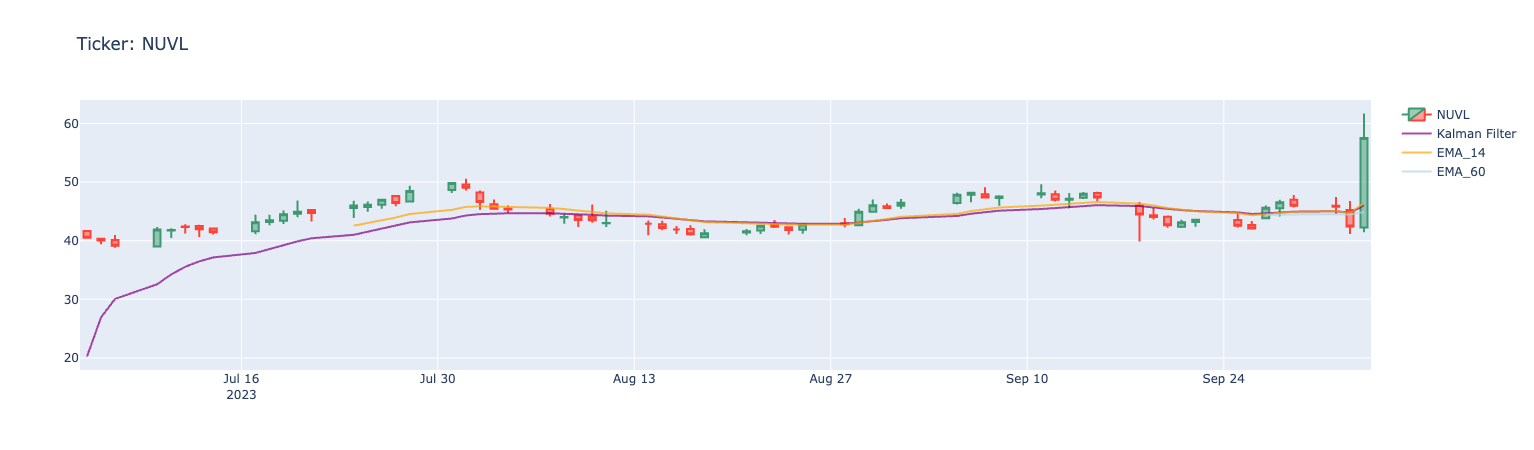

Ticker: RIVN

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 23.690000534057617

Ichimoku 9-Day Forecast: 22.450000762939453

Ichimoku 26-Day Forecast: 23.769999504089355

Choppiness (%): 53.49

RSI: 54.35137669344793

Archer MA Trending: False

EMA14 > Kalman: True

Low > Kalman: False

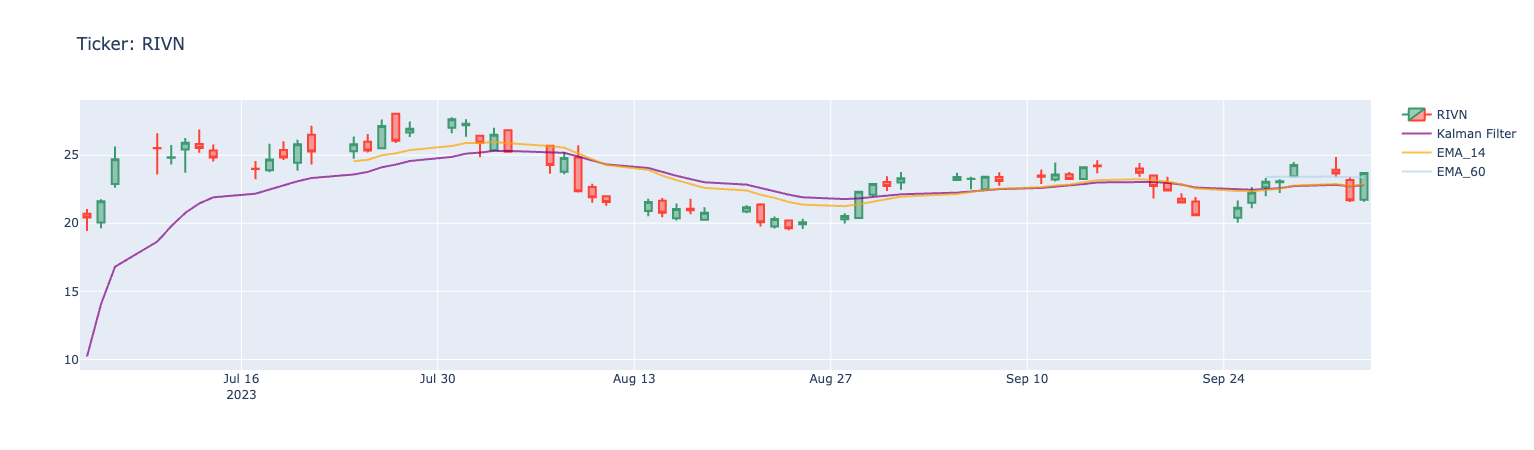

Ticker: AGL

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 18.5

Ichimoku 9-Day Forecast: 17.960000038146973

Ichimoku 26-Day Forecast: 18.97000026702881

Choppiness (%): 65.87

RSI: 53.14193869209761

Archer MA Trending: False

EMA14 > Kalman: True

Low > Kalman: False

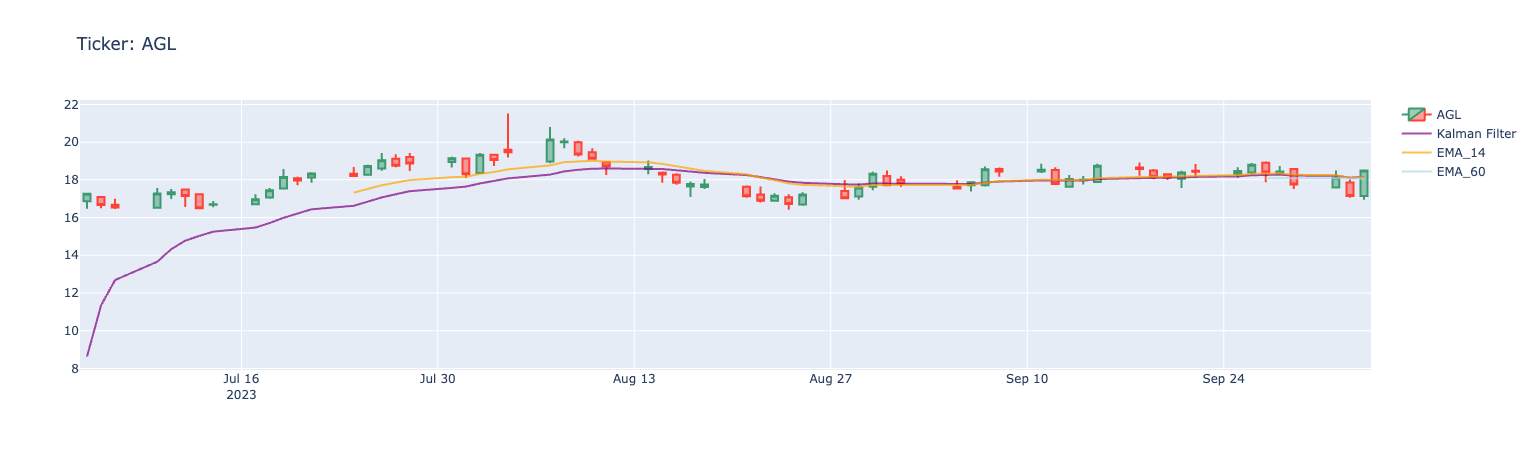

Ticker: ROAD

 AMAT &  (EMA_14 > Kalman): True

~AMAT & ~(EMA_14 > Kalman): False

Close: 38.47999954223633

Ichimoku 9-Day Forecast: 36.663249015808105

Ichimoku 26-Day Forecast: 33.8799991607666

Choppiness (%): 48.93

RSI: 65.18557566872788

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

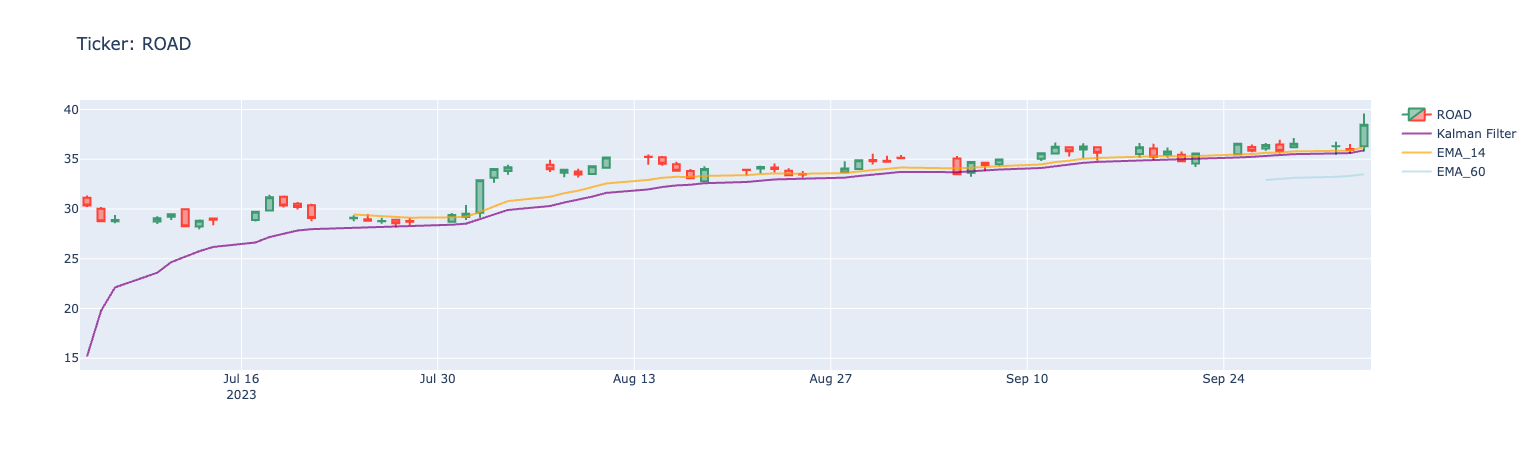

Ticker: AYI

 AMAT &  (EMA_14 > Kalman): True

~AMAT & ~(EMA_14 > Kalman): False

Close: 179.0

Ichimoku 9-Day Forecast: 170.16499710083008

Ichimoku 26-Day Forecast: 168.52999877929688

Choppiness (%): 42.95

RSI: 73.98744643074703

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

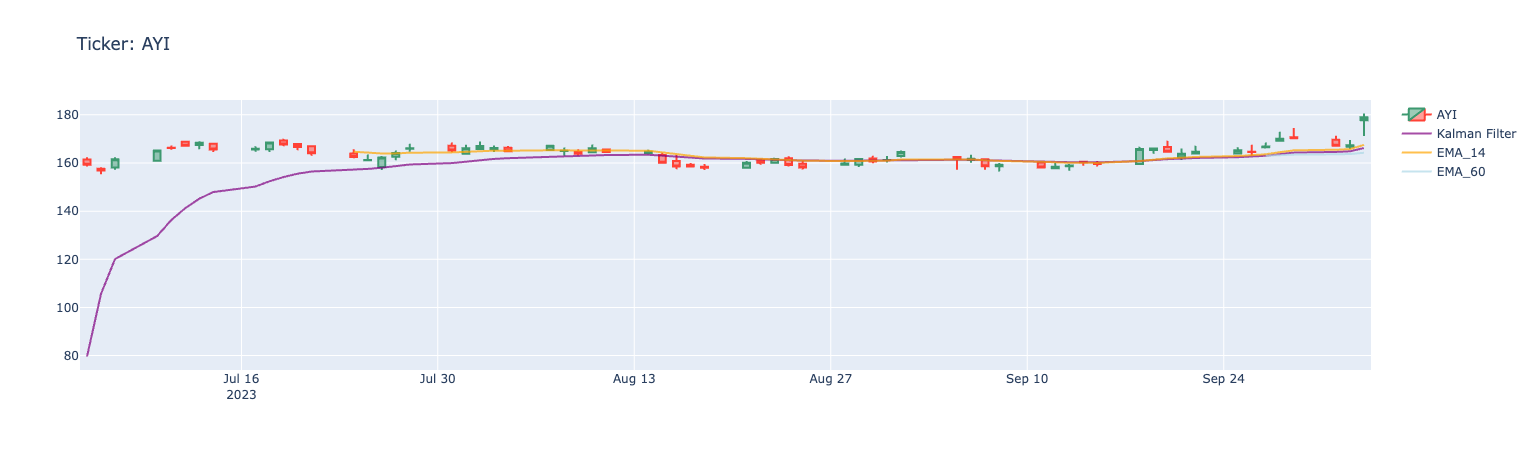

Ticker: BBDO

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 2.549999952316284

Ichimoku 9-Day Forecast: 2.6449999809265137

Ichimoku 26-Day Forecast: 2.75

Choppiness (%): 47.26

RSI: 47.19778685106971

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

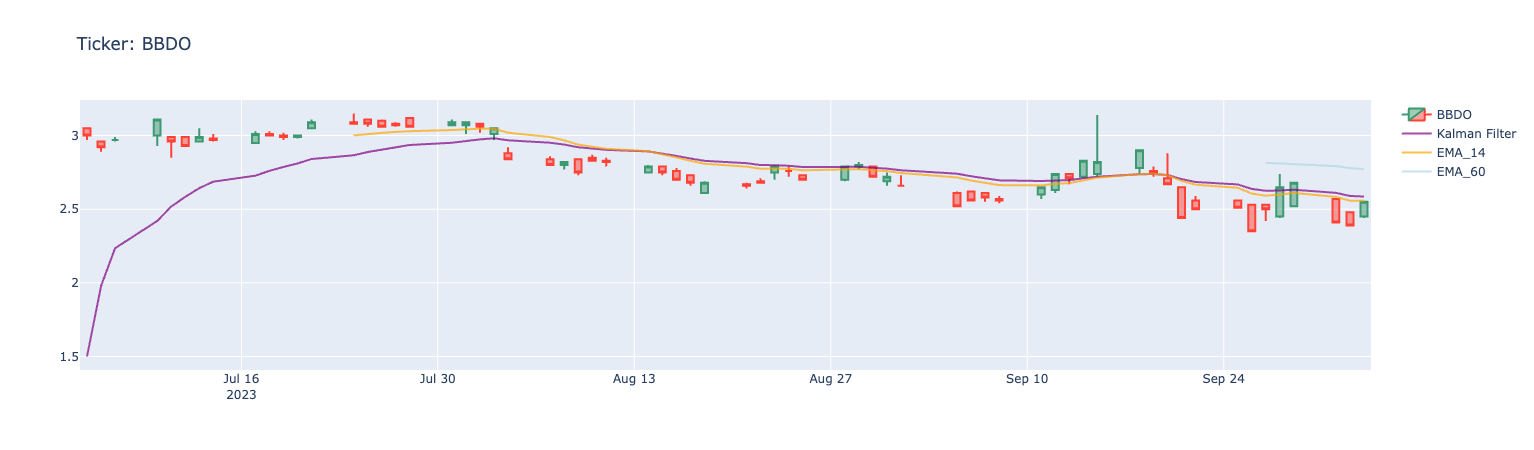

Ticker: QS

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 6.519999980926514

Ichimoku 9-Day Forecast: 6.608749985694885

Ichimoku 26-Day Forecast: 9.96999979019165

Choppiness (%): 51.59

RSI: 43.67737796300755

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

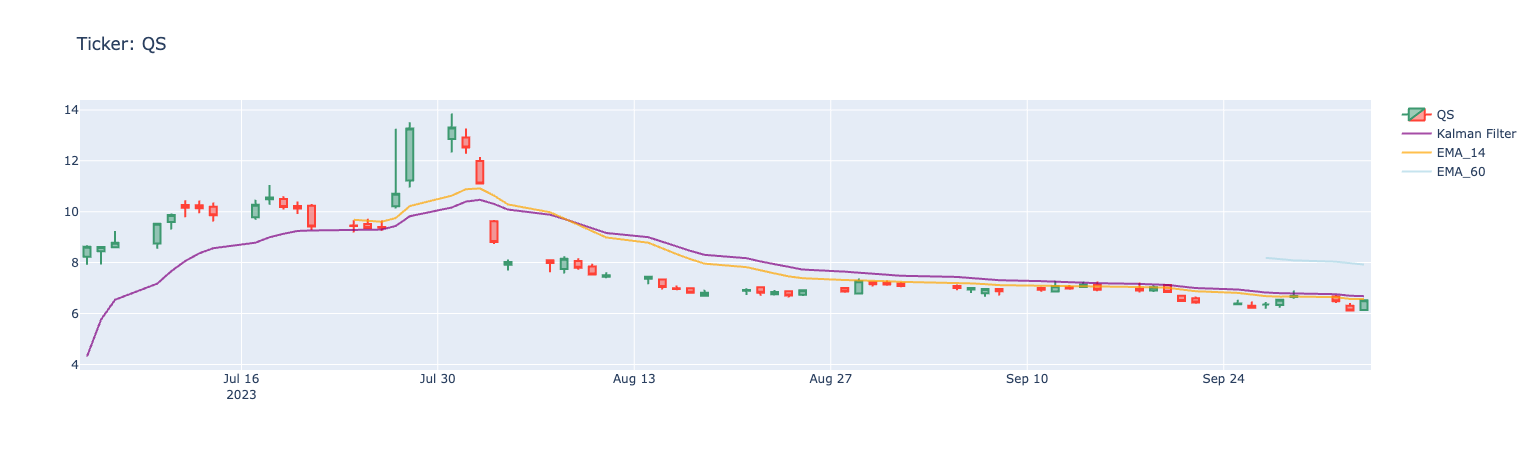

Ticker: MPW

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 5.260000228881836

Ichimoku 9-Day Forecast: 5.692500114440918

Ichimoku 26-Day Forecast: 7.829999923706055

Choppiness (%): 35.52

RSI: 33.483585174521984

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

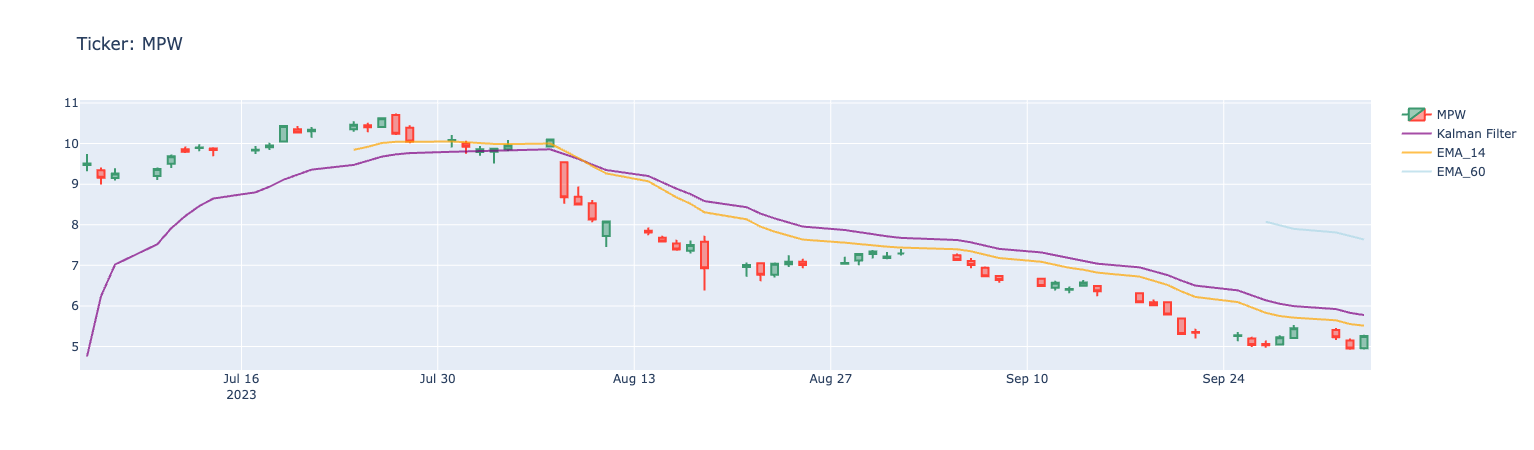

Ticker: RPM

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 98.61000061035156

Ichimoku 9-Day Forecast: 96.56500053405762

Ichimoku 26-Day Forecast: 99.58000183105469

Choppiness (%): 50.83

RSI: 57.37963219638548

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

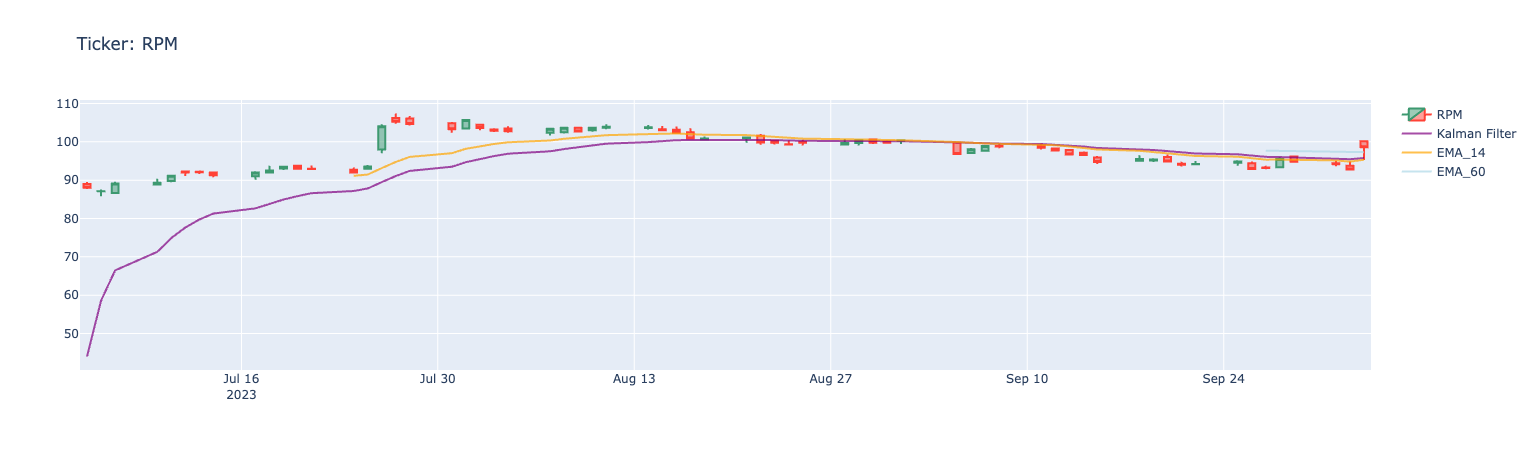

Ticker: CNM

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 30.139999389648438

Ichimoku 9-Day Forecast: 29.84249973297119

Ichimoku 26-Day Forecast: 30.53499984741211

Choppiness (%): 56.27

RSI: 55.218140536382585

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

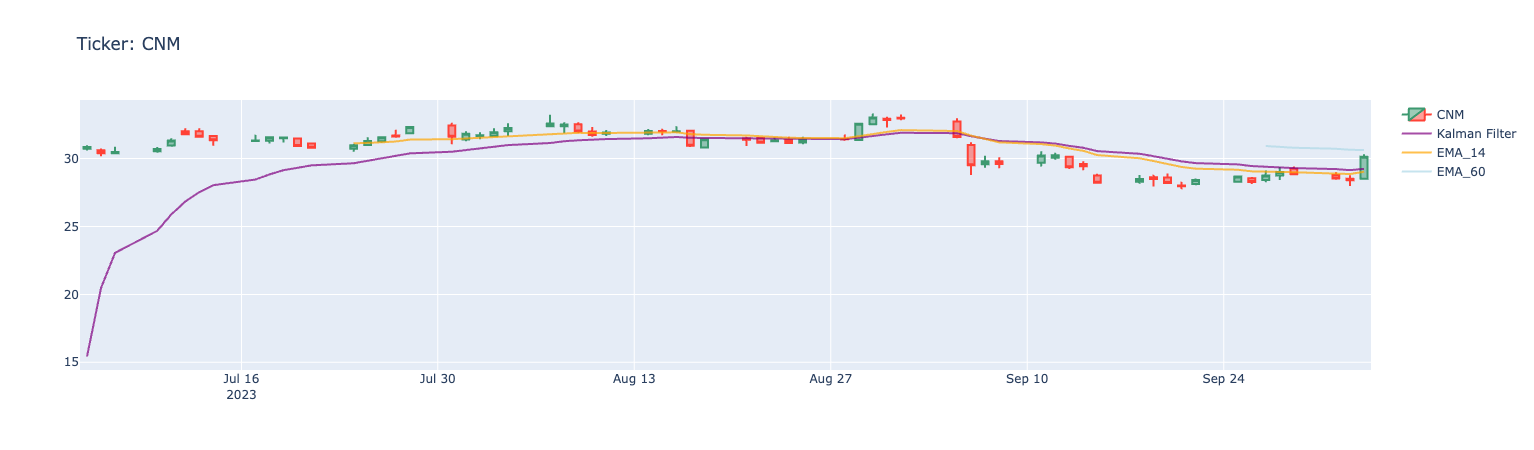

Ticker: IONQ

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 14.770000457763672

Ichimoku 9-Day Forecast: 15.848750114440918

Ichimoku 26-Day Forecast: 16.894999980926514

Choppiness (%): 44.55

RSI: 46.473948890012906

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

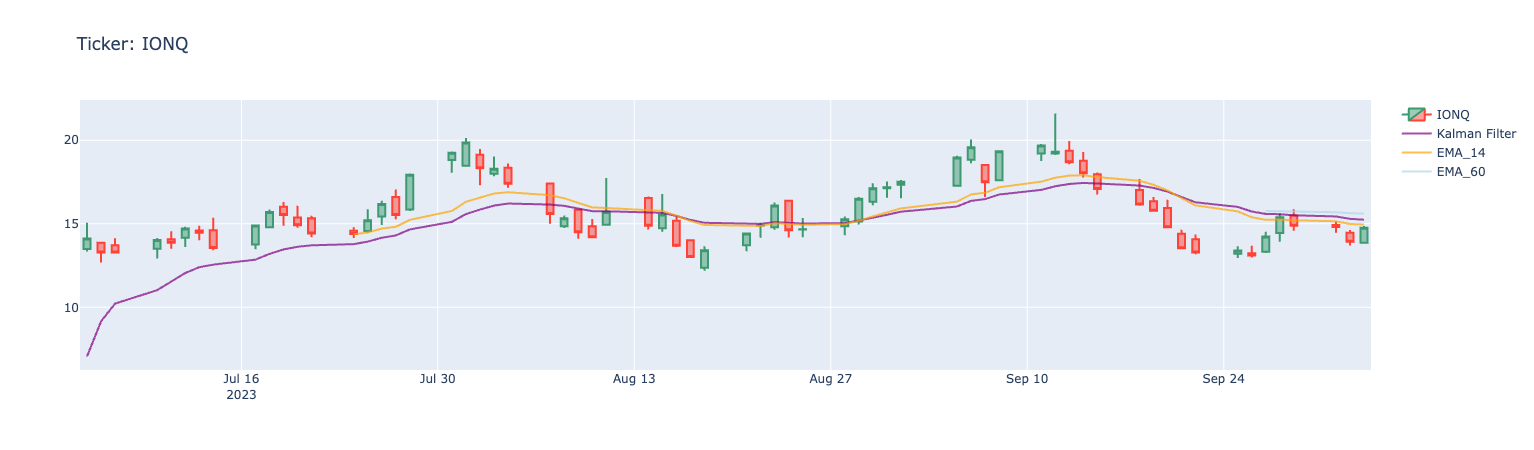

Ticker: AUR

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 2.2799999713897705

Ichimoku 9-Day Forecast: 2.7262500524520874

Ichimoku 26-Day Forecast: 3.0250000953674316

Choppiness (%): 29.55

RSI: 33.08099693669097

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

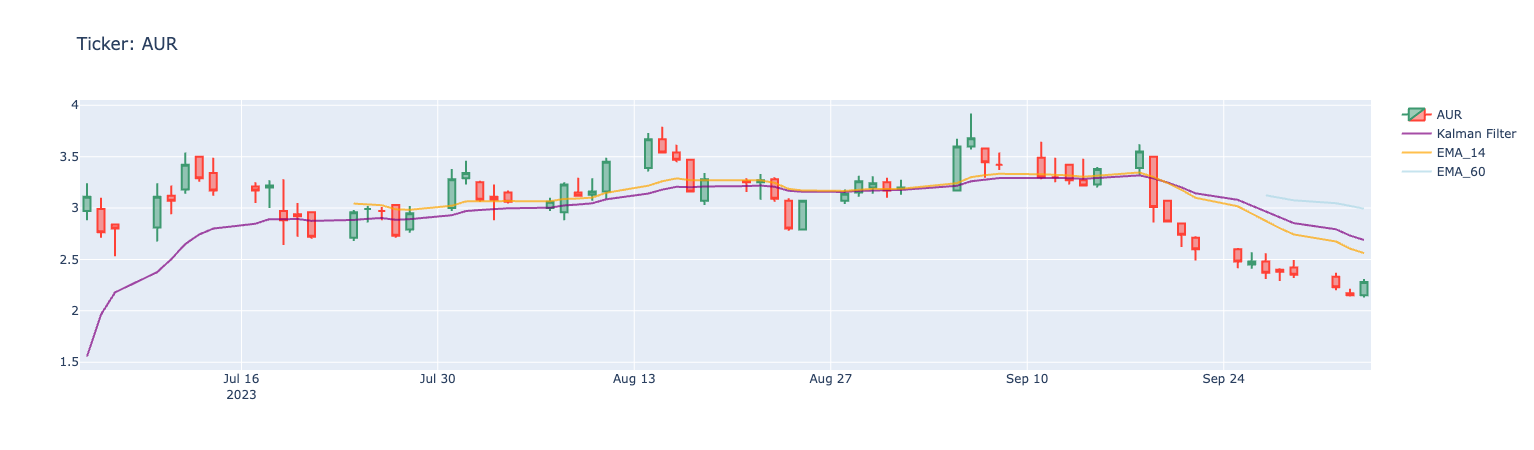

Ticker: TSLA

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 261.1600036621094

Ichimoku 9-Day Forecast: 252.5

Ichimoku 26-Day Forecast: 245.67000579833984

Choppiness (%): 42.78

RSI: 55.115408733619724

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

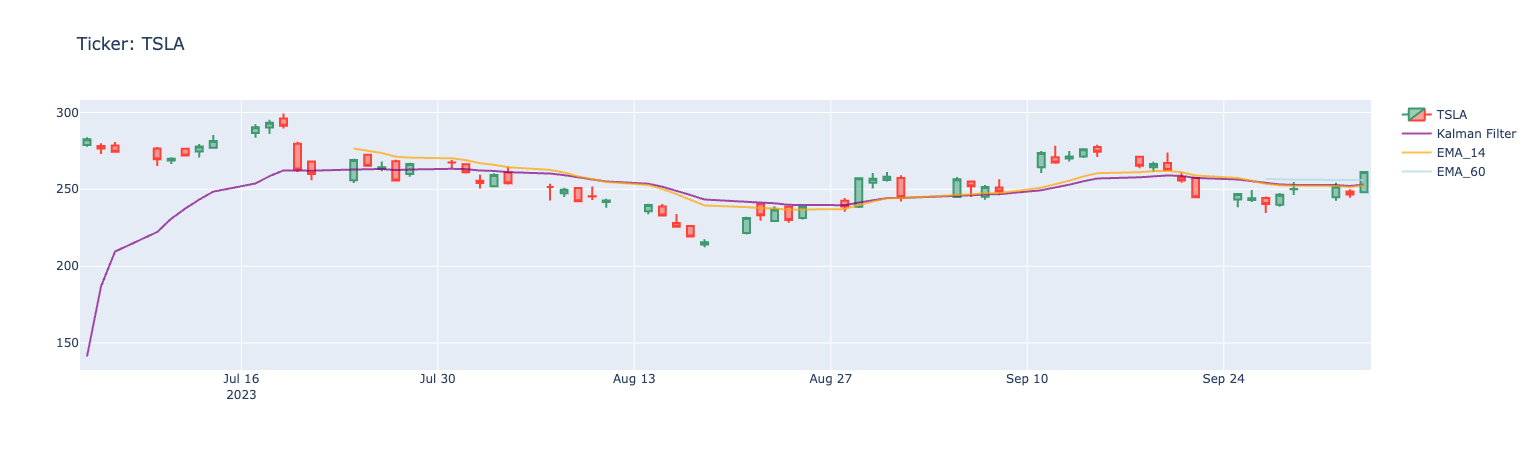

Ticker: RADLY

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 5.449999809265137

Ichimoku 9-Day Forecast: 5.419999957084656

Ichimoku 26-Day Forecast: 5.924999952316284

Choppiness (%): 51.70

RSI: 52.673469216396946

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

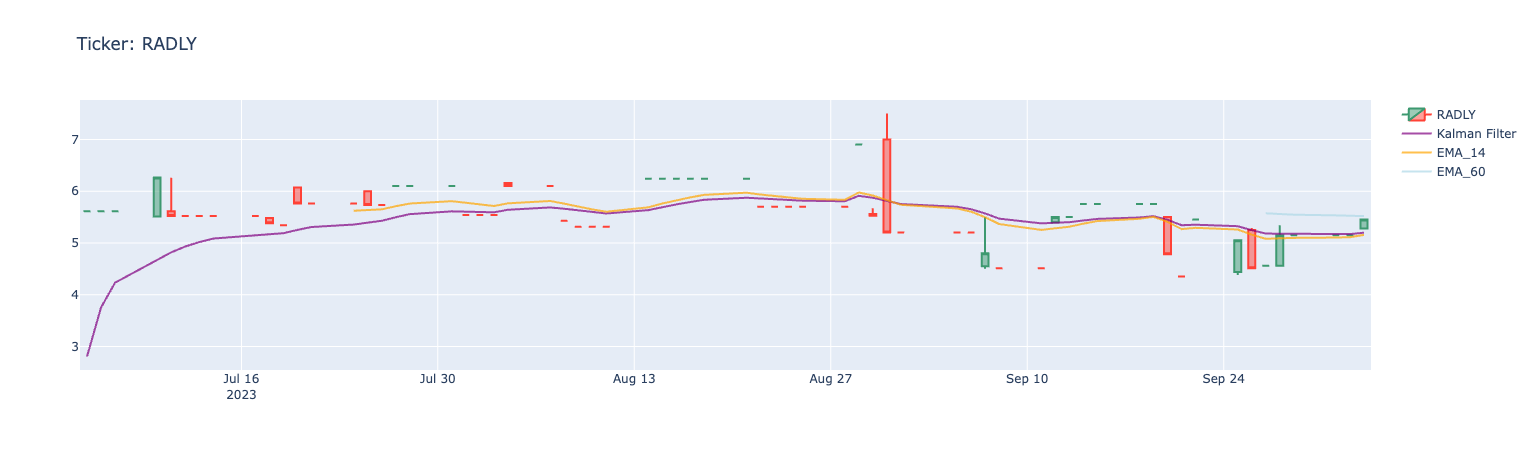

Ticker: VERX

 AMAT &  (EMA_14 > Kalman): True

~AMAT & ~(EMA_14 > Kalman): False

Close: 23.309999465942383

Ichimoku 9-Day Forecast: 22.21375036239624

Ichimoku 26-Day Forecast: 20.5600004196167

Choppiness (%): 55.22

RSI: 61.1633571140764

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

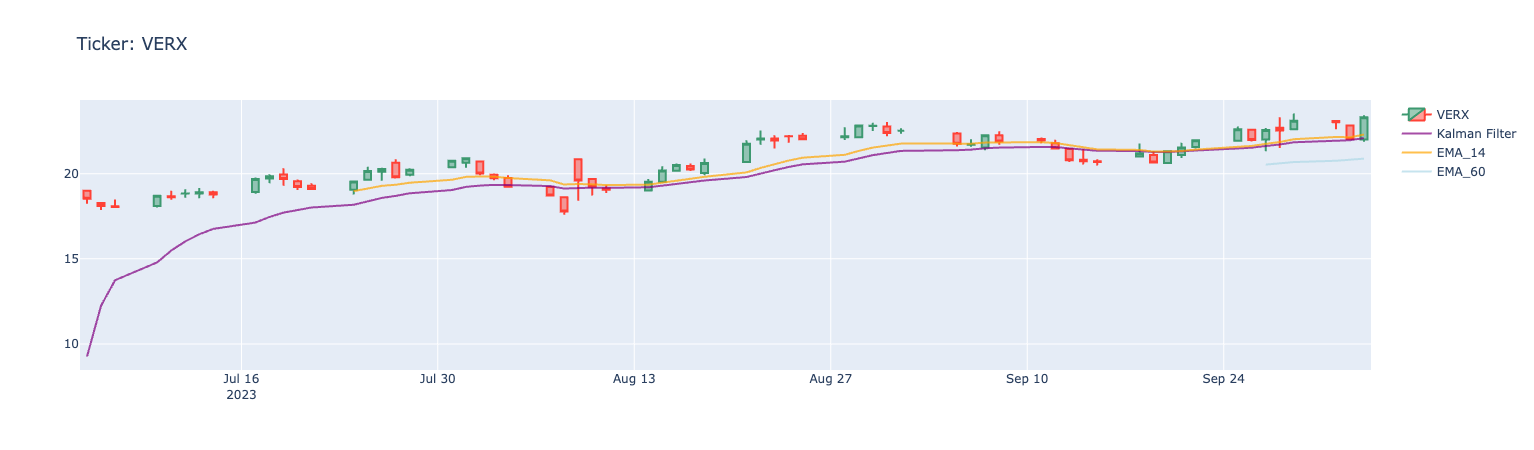

Ticker: PLTR

 AMAT &  (EMA_14 > Kalman): True

~AMAT & ~(EMA_14 > Kalman): False

Close: 15.729999542236328

Ichimoku 9-Day Forecast: 15.279999732971191

Ichimoku 26-Day Forecast: 16.960000038146973

Choppiness (%): 46.37

RSI: 53.87801591115023

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

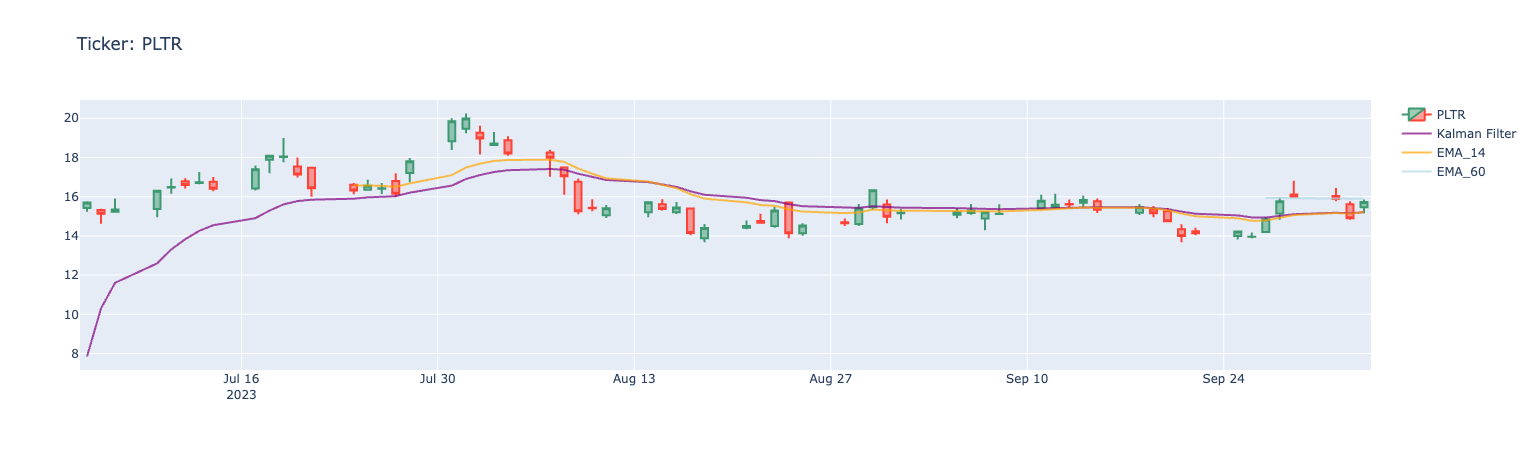

Ticker: TSCDY

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 9.850000381469727

Ichimoku 9-Day Forecast: 9.690000057220459

Ichimoku 26-Day Forecast: 9.769999980926514

Choppiness (%): 36.98

RSI: 54.04648936654602

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

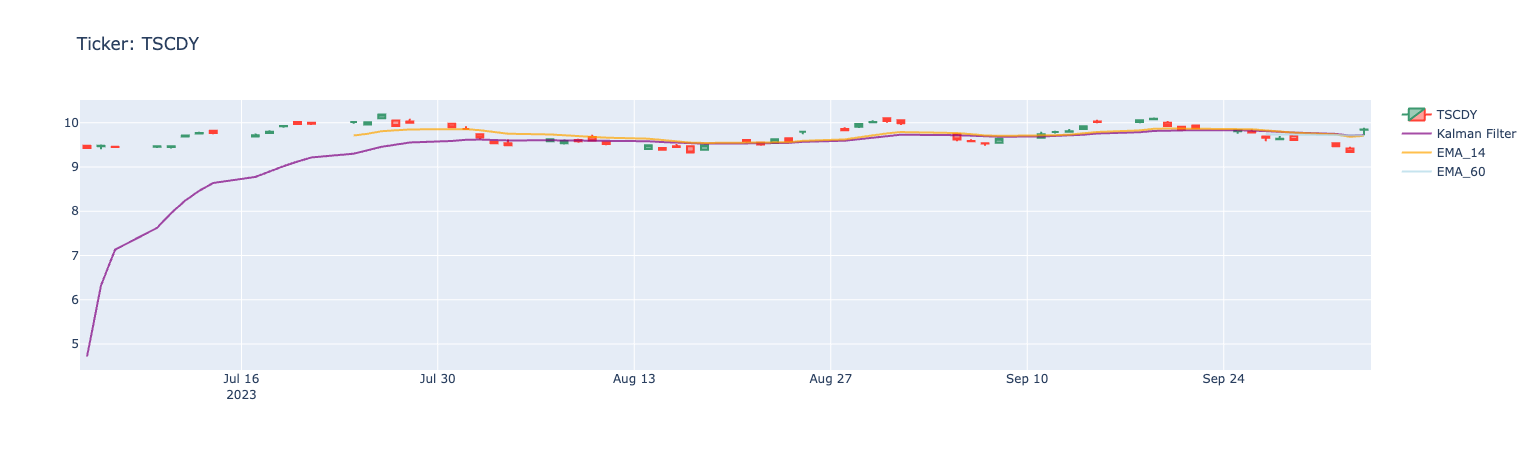

Ticker: IFNNY

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 34.209999084472656

Ichimoku 9-Day Forecast: 33.66749954223633

Ichimoku 26-Day Forecast: 38.244998931884766

Choppiness (%): 53.07

RSI: 50.26494118955302

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

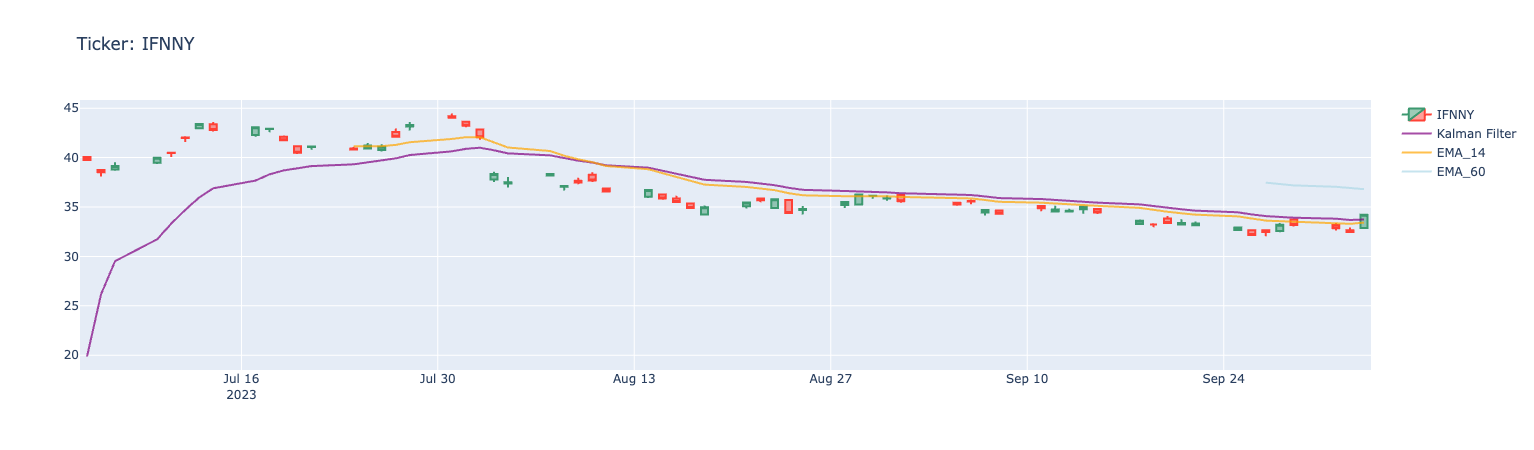

Ticker: ICAGY

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 3.630000114440918

Ichimoku 9-Day Forecast: 3.675000011920929

Ichimoku 26-Day Forecast: 3.915000081062317

Choppiness (%): 39.08

RSI: 43.07431954461127

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

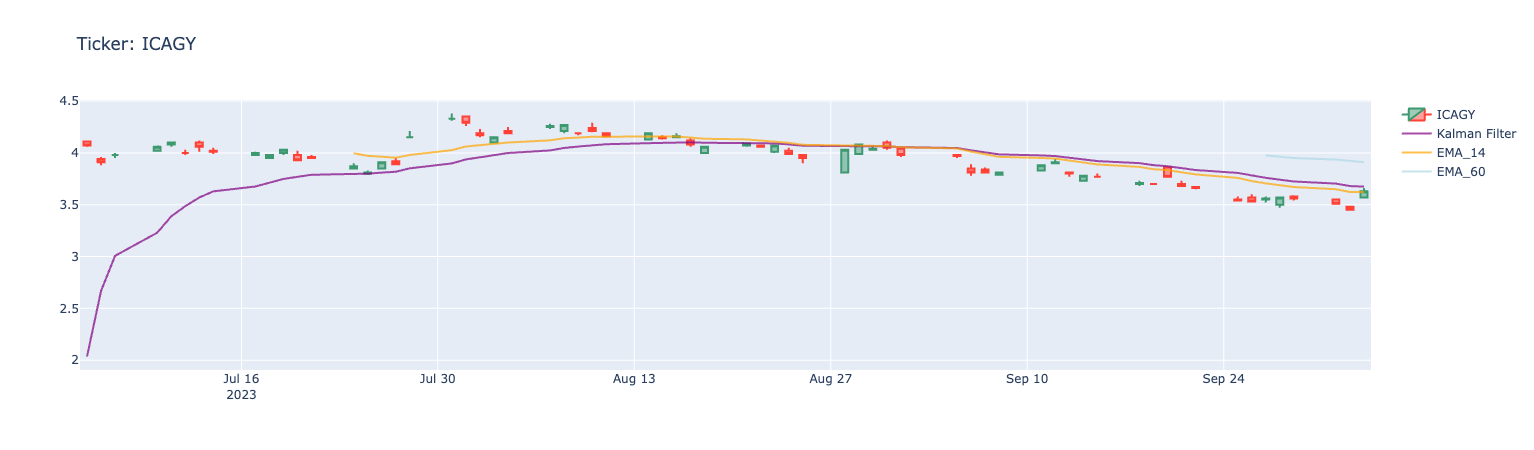

Ticker: AMN

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 87.37999725341797

Ichimoku 9-Day Forecast: 85.1299991607666

Ichimoku 26-Day Forecast: 96.77499771118164

Choppiness (%): 55.89

RSI: 52.92103475561606

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

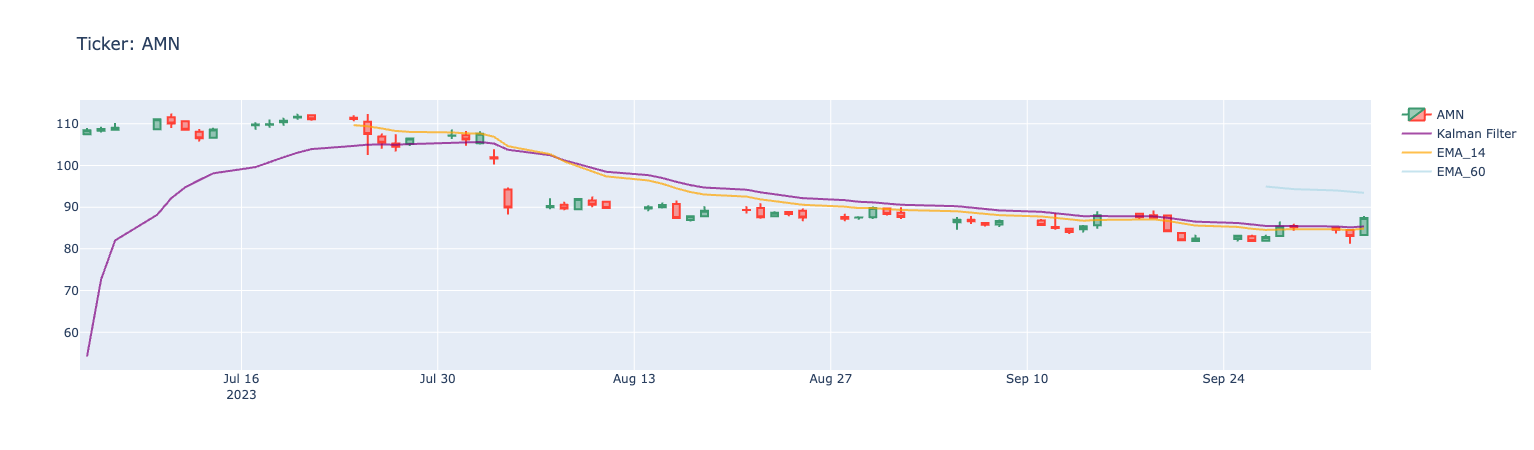

Ticker: KRTX

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 168.92999267578125

Ichimoku 9-Day Forecast: 171.75875091552734

Ichimoku 26-Day Forecast: 182.2125015258789

Choppiness (%): 52.35

RSI: 43.12891680375559

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

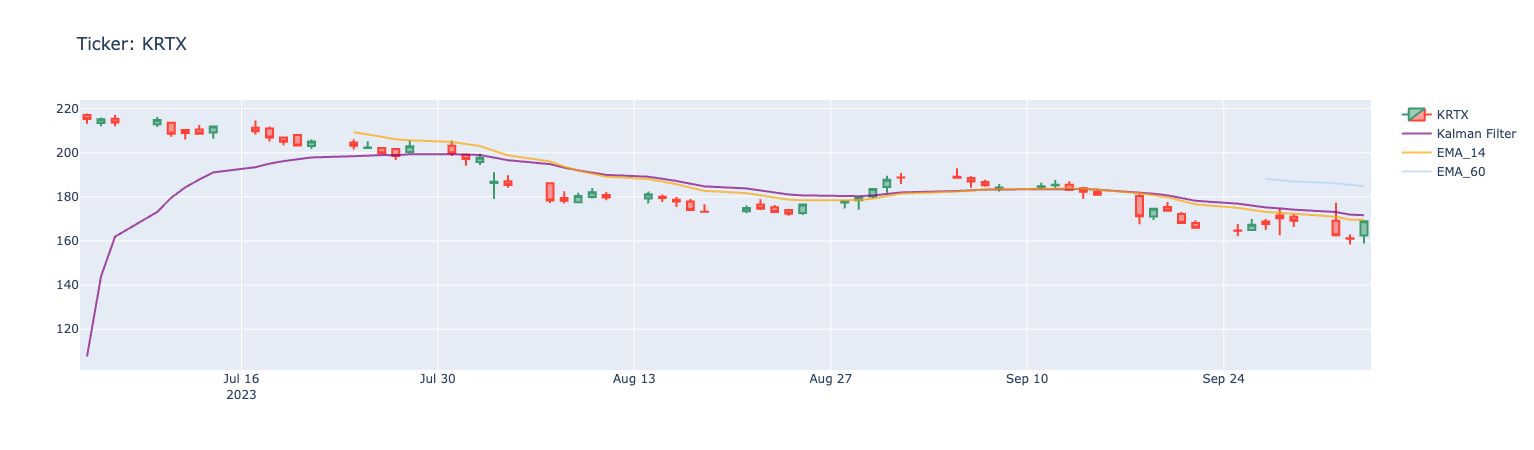

Ticker: WTM

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 1524.3499755859375

Ichimoku 9-Day Forecast: 1518.9500122070312

Ichimoku 26-Day Forecast: 1535.7550048828125

Choppiness (%): 53.08

RSI: 49.20171473400249

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

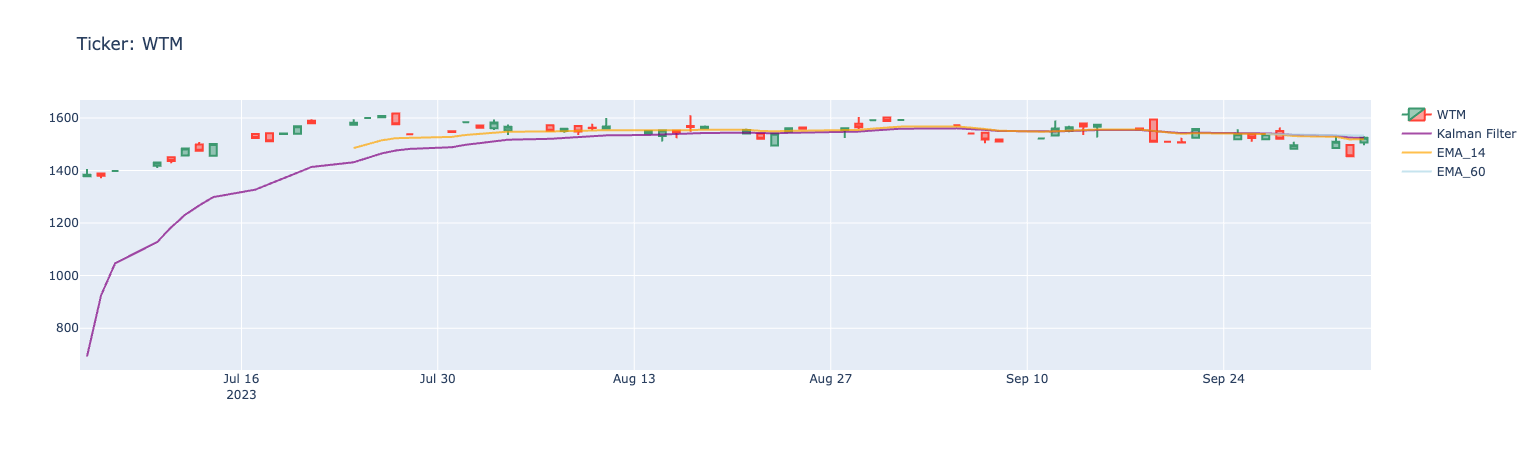

Ticker: GSAT

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): False

Close: 1.3200000524520874

Ichimoku 9-Day Forecast: 1.3550000190734863

Ichimoku 26-Day Forecast: 1.3449999690055847

Choppiness (%): 55.43

RSI: 53.25607662313591

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

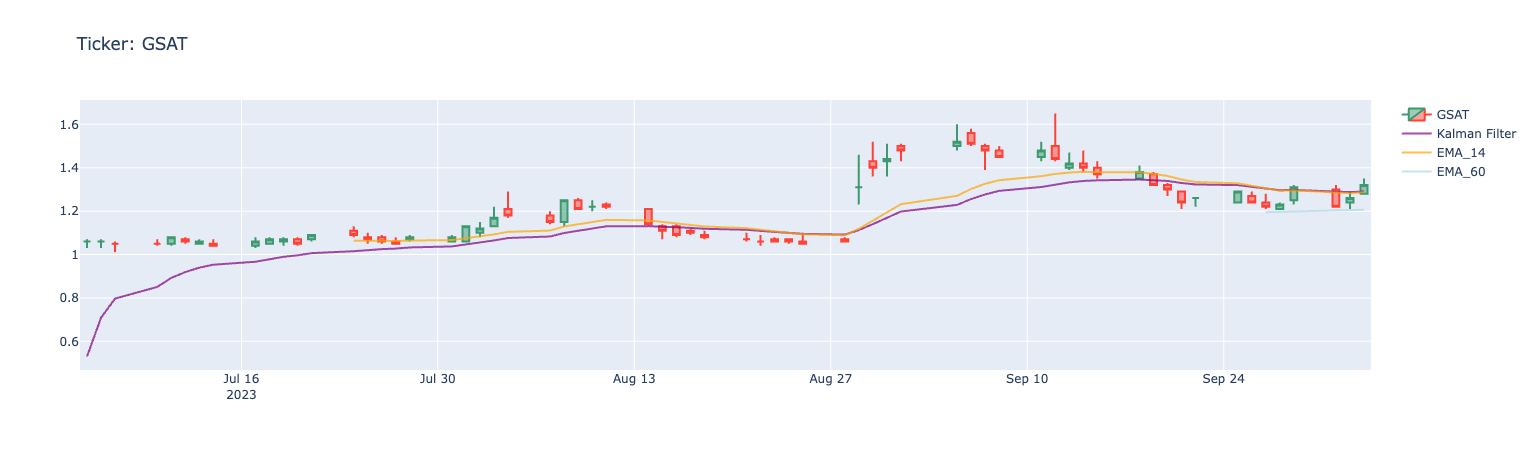

Ticker: BBSEY

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 6.389999866485596

Ichimoku 9-Day Forecast: 6.387500047683716

Ichimoku 26-Day Forecast: 6.370000123977661

Choppiness (%): 53.91

RSI: 50.768755990048525

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

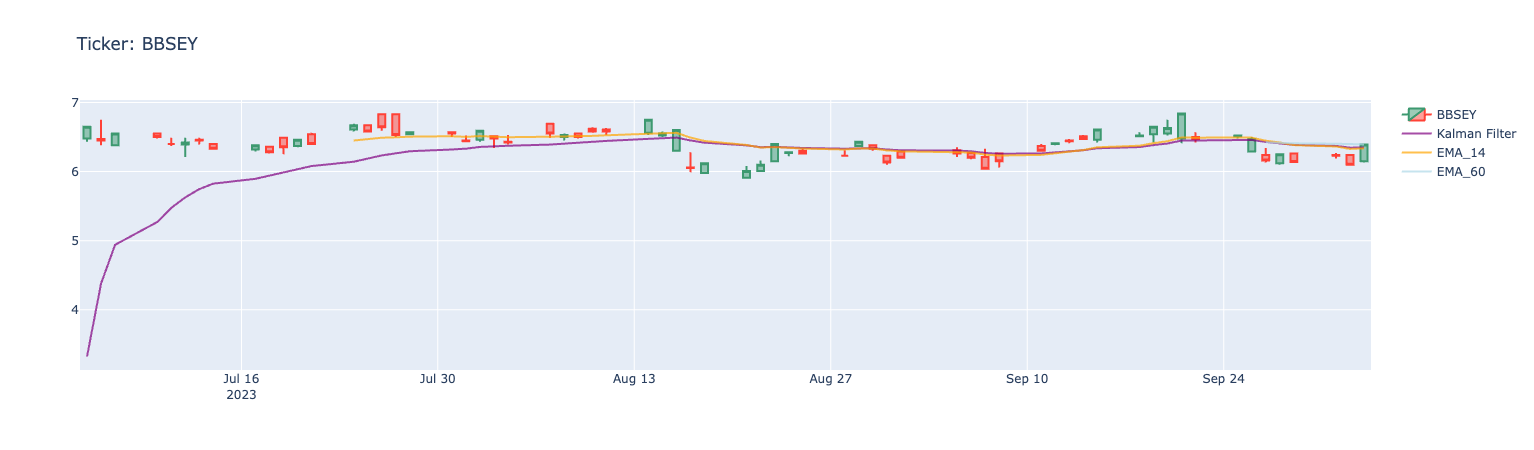

Ticker: EGFEY

 AMAT &  (EMA_14 > Kalman): False

~AMAT & ~(EMA_14 > Kalman): True

Close: 0.7590000033378601

Ichimoku 9-Day Forecast: 0.7735000103712082

Ichimoku 26-Day Forecast: 0.8140000104904175

Choppiness (%): 60.03

RSI: 47.03299665262047

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

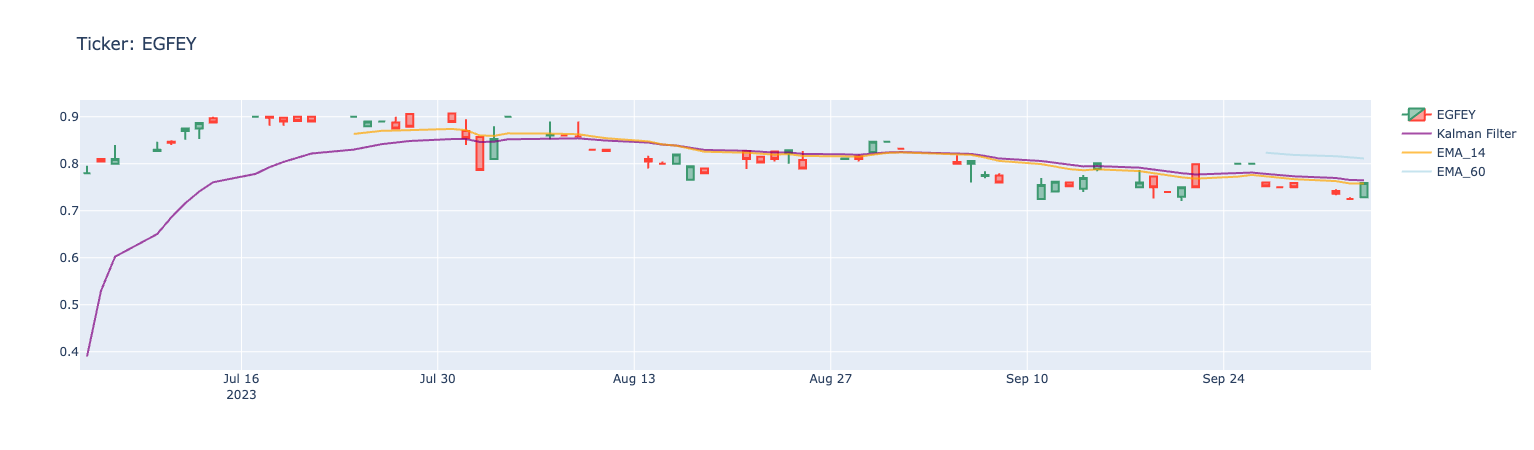

In [3]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output 
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today
url = 'https://finance.yahoo.com/gainers'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    calculate_symbol(v)
    print(f'\n\nTicker: {i}\n\n AMAT &  (EMA_14 > Kalman):',calculate_symbol(v)[8])
    print('~AMAT & ~(EMA_14 > Kalman):',calculate_symbol(v)[9])
    print('\n\nClose:',calculate_symbol(v)[1])
    print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
    print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
    print('Choppiness (%):',calculate_symbol(v)[4])
    print('RSI:',calculate_symbol(v)[5])
    print('Archer MA Trending:',calculate_symbol(v)[6])
    print('EMA14 > Kalman:',calculate_symbol(v)[7])
    print('Low > Kalman:',calculate_symbol(v)[10])
    plot(v.tail(90),i)

In [4]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [ ]:
# en fin